# Question 1



## Imports

**NumPy is used for numerical array computations and matrix operations. You can do things like:**  
Perform matrix multiplication and other linear algebra operations

```python
import numpy as np

# Define two 4x4 matrices (e.g., transformation matrices in 3D)
A = np.array([
    [1, 0, 0, 1],
    [0, 1, 0, 2],
    [0, 0, 1, 3],
    [0, 0, 0, 1]
])
B = np.array([
    [0, -1, 0, 0],
    [1,  0, 0, 0],
    [0,  0, 1, 0],
    [0,  0, 0, 1]
])

# Multiply the matrices
product = A @ B
print(product)
```

**Sympy is used for symbolic math. You can do things like:**  
Define symbolic variables and build a 4x4 homogeneous transformation matrix for 3D

```python
import sympy as sp

# Define symbolic variables
theta = sp.symbols('theta')
tx, ty, tz = sp.symbols('tx ty tz')

# Build a 4x4 homogeneous transformation matrix for 3D
T = sp.Matrix([
    [sp.cos(theta), -sp.sin(theta), 0, tx],
    [sp.sin(theta),  sp.cos(theta), 0, ty],
    [0,             0,             1, tz],
    [0,             0,             0, 1]
])

# Print Results
sp.pprint(T)
```

**SpatialMath is used for spatial transformations and robotics kinematics in 3D. You can do things like:**  
Create rotation and transformation matrices, and combine rotations with translations<br>
SE and SO stand for Special Euclidian and Orthoganal grouped matrixes


```python
from spatialmath import SE3, SO3
import numpy as np

# Create a 3D rotation matrix: 45° rotation about the z-axis
R = SO3.Rz(np.deg2rad(45))
print("Rotation Matrix:\n", R.A)

# Create a 3D homogeneous transformation: translation + rotation
T = SE3([1, 2, 3]) * SE3.Rz(np.deg2rad(30))
print("Homogeneous Transformation Matrix:\n", T.A)
```

In [24]:
import sympy as sp
import numpy as np
from spatialmath import SO3, SE3

## Solve Forward Kinimatics. Find:
$^{0}T_{c} = {}^{0}T_{1} \, {}^{1}T_{2} \, {}^{2}T_{c}$

The translation Matrixes are simple

In [25]:
d1, d2, d3 = sp.symbols('d1 d2 d3')

t01 = sp.Matrix([0,0,d1]) #read as the translation of frame 1 in respect to frame 0
t12 = sp.Matrix([0,0,d2])
t2c = sp.Matrix([0,0,d3])

The rotation matrixes take a little more effort

In [26]:
theta1, theta2 = sp.symbols('theta1 theta2')

# Find R01 (read as the rotation matrix of 1 in respect to 0)

Rx90 = SO3.Rx(sp.pi/2) #90 degrees
RyTheta1 = SO3.Ry(theta1)
R01 = Rx90 * RyTheta1

sp.Matrix(R01.A)


Matrix([
[cos(theta1), 0,  sin(theta1)],
[sin(theta1), 0, -cos(theta1)],
[          0, 1,            0]])

In [27]:
# Find R12

RyTheta2 = SO3.Ry(theta2)
R12 = Rx90 * RyTheta2

sp.Matrix(R12.A)

Matrix([
[cos(theta2), 0,  sin(theta2)],
[sin(theta2), 0, -cos(theta2)],
[          0, 1,            0]])

In [28]:
# Find R2c

Rz270 = SO3.Rz(-sp.pi/2)
R2c = Rz270

sp.Matrix(R2c.A)

Matrix([
[ 0, 1, 0],
[-1, 0, 0],
[ 0, 0, 1]])

So now we can put together the transformation matrixes

In [29]:
def make_transform(R, t):
    """
    Creates a 4x4 homogeneous transformation matrix T from a rotation matrix R and a translation vector t.
    
    Parameters:
      R : A rotation matrix. This can be an object with a .A attribute (like an SO3 object)
          or a standard Sympy Matrix.
      t : A 3x1 translation vector. It should be a column vector.
      
    Returns:
      T : A 4x4 homogeneous transformation matrix as a Sympy Matrix.
    """
    # Convert the rotation matrix to a standard Sympy Matrix if necessary.
    try:
        R_mat = sp.Matrix(R.A)
    except AttributeError:
        R_mat = sp.Matrix(R)
    
    # Ensure t is a column vector.
    t_vec = sp.Matrix(t)
    if t_vec.shape[1] != 1:
        t_vec = t_vec.T if t_vec.shape[0] == 1 else t_vec
    
    # Build the transformation matrix by concatenating R and t, and appending the bottom row.
    T = sp.Matrix.vstack(
        sp.Matrix.hstack(R_mat, t_vec),
        sp.Matrix([[0, 0, 0, 1]])
    )
    return T

In [30]:
T01 = make_transform(R01, t01)
sp.Matrix(T01)

Matrix([
[cos(theta1), 0,  sin(theta1),  0],
[sin(theta1), 0, -cos(theta1),  0],
[          0, 1,            0, d1],
[          0, 0,            0,  1]])

In [31]:
T12 = make_transform(R12, t12)
sp.Matrix(T12)

Matrix([
[cos(theta2), 0,  sin(theta2),  0],
[sin(theta2), 0, -cos(theta2),  0],
[          0, 1,            0, d2],
[          0, 0,            0,  1]])

In [32]:
T2c = make_transform(R2c, t2c)
sp.Matrix(T2c)

Matrix([
[ 0, 1, 0,  0],
[-1, 0, 0,  0],
[ 0, 0, 1, d3],
[ 0, 0, 0,  1]])

In [33]:
# Construct final transform matrix

T0c = T01 * T12 * T2c
T0c

Matrix([
[-sin(theta1), cos(theta1)*cos(theta2), sin(theta2)*cos(theta1),  d2*sin(theta1) + d3*sin(theta2)*cos(theta1)],
[ cos(theta1), sin(theta1)*cos(theta2), sin(theta1)*sin(theta2), -d2*cos(theta1) + d3*sin(theta1)*sin(theta2)],
[           0,             sin(theta2),            -cos(theta2),                          d1 - d3*cos(theta2)],
[           0,                       0,                       0,                                            1]])

In [34]:
# extract final rotation matrix
R0c = T0c[:3,:3]
R0c

Matrix([
[-sin(theta1), cos(theta1)*cos(theta2), sin(theta2)*cos(theta1)],
[ cos(theta1), sin(theta1)*cos(theta2), sin(theta1)*sin(theta2)],
[           0,             sin(theta2),            -cos(theta2)]])

In [35]:
# extract final translation matrix
t0c = T0c[:3, 3]
t0c

Matrix([
[ d2*sin(theta1) + d3*sin(theta2)*cos(theta1)],
[-d2*cos(theta1) + d3*sin(theta1)*sin(theta2)],
[                         d1 - d3*cos(theta2)]])

## Solve Inverse Kinematics 
Determine $ \theta_1 $ and $ \theta_2 $ required to achieve the desired position $ t $.

### Position Equations:
The desired position is given by:

$ t = [x_c, y_c, z_c] $

where:

$ x_c = f(\theta_1, \theta_2) $

$ y_c = f(\theta_1, \theta_2) $

$ z_c = f(\theta_1, \theta_2) $

From these equations, $ \theta_1 $ and $ \theta_2 $ can be solved to achieve the desired position.


In [36]:
# Remember:
# t0c is the position vector from o to c
# so lets extract x, y, and z from that

xc = sp.symbols(r'{}^0x_c')
yc = sp.symbols(r'{}^0y_c')
zc = sp.symbols(r'{}^0z_c')

# xc, yc, zc = t0c[0], t0c[1], t0c[2]

#x, y, and z here are functions of theta1 and theta2
xc

{}^0x_c

In [37]:
yc

{}^0y_c

In [38]:
zc

{}^0z_c

### Now lets solve the System of Equations

In [39]:
#define the equations
eq1 = sp.Eq(t0c[0], xc)
eq1

Eq(d2*sin(theta1) + d3*sin(theta2)*cos(theta1), {}^0x_c)

In [40]:
eq2 = sp.Eq(t0c[1], yc)
eq2

Eq(-d2*cos(theta1) + d3*sin(theta1)*sin(theta2), {}^0y_c)

In [41]:
eq3 = sp.Eq(t0c[2],zc)
eq3

Eq(d1 - d3*cos(theta2), {}^0z_c)

In [42]:
# Now solve - quite expensive
solutions = sp.solve([eq1, eq2, eq3], (theta1, theta2))

In [43]:
solutions # 4 solutions, first is theta1 and second is theta2. 

[(2*atan((d2 - sqrt(-d1**2 + 2*d1*{}^0z_c + d2**2 + d3**2 - {}^0x_c**2 - {}^0z_c**2))/(d3*sqrt((-d1**2 + 2*d1*{}^0z_c + d3**2 - {}^0z_c**2)/d3**2) + {}^0x_c)),
  acos((d1 - {}^0z_c)/d3)),
 (-2*atan((d2 - sqrt(-d1**2 + 2*d1*{}^0z_c + d2**2 + d3**2 - {}^0x_c**2 - {}^0z_c**2))/(d3*sqrt(-(d1**2 - 2*d1*{}^0z_c - d3**2 + {}^0z_c**2)/d3**2) - {}^0x_c)),
  -acos((d1 - {}^0z_c)/d3) + 2*pi),
 (2*atan((d2 + sqrt(-d1**2 + 2*d1*{}^0z_c + d2**2 + d3**2 - {}^0x_c**2 - {}^0z_c**2))/(d3*sqrt((-d1**2 + 2*d1*{}^0z_c + d3**2 - {}^0z_c**2)/d3**2) + {}^0x_c)),
  acos((d1 - {}^0z_c)/d3)),
 (-2*atan((d2 + sqrt(-d1**2 + 2*d1*{}^0z_c + d2**2 + d3**2 - {}^0x_c**2 - {}^0z_c**2))/(d3*sqrt(-(d1**2 - 2*d1*{}^0z_c - d3**2 + {}^0z_c**2)/d3**2) - {}^0x_c)),
  -acos((d1 - {}^0z_c)/d3) + 2*pi)]

In [44]:
solution_theta1 = solutions[0][0] #the first index is the solution number, 0-3. The second index is theta1 or theta2
solution_theta1

2*atan((d2 - sqrt(-d1**2 + 2*d1*{}^0z_c + d2**2 + d3**2 - {}^0x_c**2 - {}^0z_c**2))/(d3*sqrt((-d1**2 + 2*d1*{}^0z_c + d3**2 - {}^0z_c**2)/d3**2) + {}^0x_c))

In [45]:
solution_theta2 = solutions[0][1]
solution_theta2

acos((d1 - {}^0z_c)/d3)

In [46]:
# verify
sp.simplify(eq1.subs({theta1: solution_theta1, theta2:solution_theta2}))

True

After pasting the solutions into ChatGPT so it could format it nicely, these are the solutions! In case ChatGPT made up part of it, double check with the solutions variable. 
---

**Solution 1:**

$$
\theta_1 = 2\,\operatorname{atan}\!\left(\frac{d_2 - \sqrt{-d_1^2 + 2\,d_1\,{}^0z_c + d_2^2 + d_3^2 - {}^0x_c^2 - {}^0z_c^2}}{d_3\,\sqrt{\dfrac{-d_1^2 + 2\,d_1\,{}^0z_c + d_3^2 - {}^0z_c^2}{d_3^2}} + {}^0x_c}\right)
\quad,\quad
\theta_2 = \arccos\!\left(\frac{d_1 - {}^0z_c}{d_3}\right)
$$

---

**Solution 2:**

$$
\theta_1 = -2\,\operatorname{atan}\!\left(\frac{d_2 - \sqrt{-d_1^2 + 2\,d_1\,{}^0z_c + d_2^2 + d_3^2 - {}^0x_c^2 - {}^0z_c^2}}{d_3\,\sqrt{\dfrac{-\left(d_1^2 - 2\,d_1\,{}^0z_c - d_3^2 + {}^0z_c^2\right)}{d_3^2}} - {}^0x_c}\right)
\quad,\quad
\theta_2 = -\arccos\!\left(\frac{d_1 - {}^0z_c}{d_3}\right) + 2\pi
$$

---

**Solution 3:**

$$
\theta_1 = 2\,\operatorname{atan}\!\left(\frac{d_2 + \sqrt{-d_1^2 + 2\,d_1\,{}^0z_c + d_2^2 + d_3^2 - {}^0x_c^2 - {}^0z_c^2}}{d_3\,\sqrt{\dfrac{-d_1^2 + 2\,d_1\,{}^0z_c + d_3^2 - {}^0z_c^2}{d_3^2}} + {}^0x_c}\right)
\quad,\quad
\theta_2 = \arccos\!\left(\frac{d_1 - {}^0z_c}{d_3}\right)
$$

---

**Solution 4:**

$$
\theta_1 = -2\,\operatorname{atan}\!\left(\frac{d_2 + \sqrt{-d_1^2 + 2\,d_1\,{}^0z_c + d_2^2 + d_3^2 - {}^0x_c^2 - {}^0z_c^2}}{d_3\,\sqrt{\dfrac{-\left(d_1^2 - 2\,d_1\,{}^0z_c - d_3^2 + {}^0z_c^2\right)}{d_3^2}} - {}^0x_c}\right)
\quad,\quad
\theta_2 = -\arccos\!\left(\frac{d_1 - {}^0z_c}{d_3}\right) + 2\pi
$$

---


## Intuition
I want to gain an intuition for what these solutions are, that is what this next section is about. Lets just look at the first set of solutions. Lets also just look at our z value

Lets set our variables

$d_1 = 1.2$ meters

$d_2 = d_3 = 0.8$ meters



In [47]:
intu_solTheta2 = solutions[0][1].subs({d1:1.2, d2:0.8, d3:0.8})
print(intu_solTheta2)


acos(1.5 - 1.25*{}^0z_c)


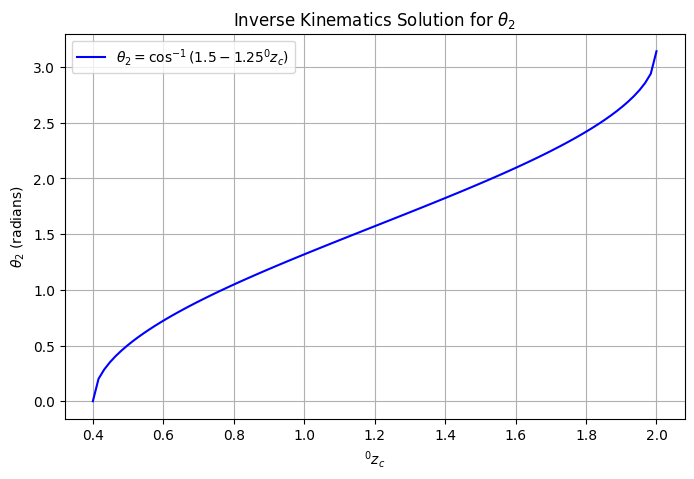

In [48]:
# lets plot this thing
# first, you need to convert it to a numerical function
theta2_function = sp.lambdify(zc, intu_solTheta2, 'numpy')
# define a range for zc
zcValues = np.linspace(0.4,2,100)
theta2Values = theta2_function(zcValues)
# now plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(zcValues, theta2Values, label=r'$\theta_2 = \cos^{-1}(1.5 - 1.25{}^0z_c)$', color='b')
plt.xlabel(r'${}^0z_c$')
plt.ylabel(r'$\theta_2$ (radians)')
plt.title('Inverse Kinematics Solution for $\\theta_2$')
plt.legend()
plt.grid()
plt.show()

This is saying that ${}^0z_c$ is only allowed to be between 0.4 and 2.0

# Question 2

In [49]:
# calculating the spatial rotation matrix derivitive
import sympy as sp
theta1_dot = sp.symbols(r"\dot{\theta_1}")
theta2_dot = sp.symbols(r"\dot{\theta_2}")

# theta1_dot = 1
w01_0 = sp.Matrix([0,0,theta1_dot])
w12_1 = sp.Matrix([0,0,theta2_dot])
w2c_2 = sp.Matrix([0,0,0])
w12_spatial = R01 @ w12_1
w12_spatial

c:\Users\calebhottes\AppData\Local\Programs\Python\Python313\Lib\site-packages\spatialmath\baseposematrix.py:611: SyntaxWarning: invalid escape sequence '\m'
  """


TypeError: @ only applies to pose composition